# Lesson 2: Deploy an image classifier

Tasks:
1. Train a simple image classifier
2. Deploy the model to a web service

### Notebook setup

In [1]:
from pathlib import Path
from PIL import Image
from typing import List

In [43]:
import os
cwd = Path(os.getcwd())
if "exercises" == cwd.parts[-1]:
    print(f"Changing cwd to {cwd.parent}")
    os.chdir(cwd.parent)
elif "fastbook" in [x.name for x in cwd.iterdir()]:
    dest = cwd / "fastbook"
    print(f"Changing cwd to {dest}")
    os.chdir(dest)
assert cwd.parts[-1] == "fastbook", f"Unexpected cwd location at {cwd}"
print(f"cwd is {cwd}")

cwd is /teamspace/studios/this_studio/fastbook


### Data curation

In [3]:
animals = 'zebra','horse'
data_dir = Path('data/animals')
data_dir.mkdir(parents=True, exist_ok=True)

In [44]:
DOWNLOAD_DATA = False

from duckduckgo_search import DDGS
from fastai.vision.utils import download_images
from time import sleep

def search_images(term, max_images=30) -> List[str]:
    print(f"Searching for '{term}'")
    with DDGS() as ddgs:
        ddgs_images_gen = ddgs.images(term, max_results=max_images)
        return [x["image"] for x in ddgs_images_gen]

if DOWNLOAD_DATA:
    for nm in animals:
        dest = (data_dir/nm)
        dest.mkdir(exist_ok=True, parents=True)
        download_images(dest, urls=search_images(f'{nm} photo', max_images=20))
        sleep(10)
        download_images(dest, urls=search_images(f'{nm} sun photo', max_images=20))
        sleep(10)
        download_images(dest, urls=search_images(f'{nm} resting photo', max_images=20))
        sleep(10)
        # resize_images(dest, max_size=400, dest=dest)

Folder data/animals/zebra contains 52 files


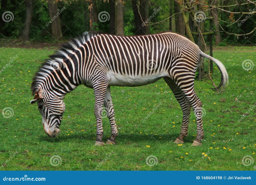

Folder data/animals/horse contains 56 files


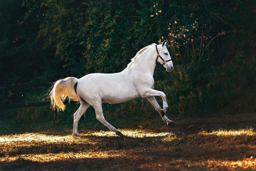

In [45]:
for a in animals:
    folder = (data_dir / a)
    files = get_image_files(folder)
    print(f"Folder {folder} contains {len(files)} files")
    x = Image.open(files[0])
    x.thumbnail((256,256))
    display(x)

In [46]:
from fastai.vision.all import untar_data, URLs, ImageDataLoaders, get_image_files, Resize, vision_learner, resnet34, error_rate, verify_images

In [47]:
files = get_image_files(data_dir)
files

(#108) [Path('data/animals/horse/002489a8-d4b0-4769-a8a3-3e9476f51f53.jpeg'),Path('data/animals/horse/0576b311-40b1-49a1-9cc0-84b0c5c27150.jpg'),Path('data/animals/horse/1095cdb1-56f6-4fcf-9c67-bef1a29322bf.jpg'),Path('data/animals/horse/1478f1f3-e884-4095-9b1e-2594c387c937.jpg'),Path('data/animals/horse/1e05c9e4-ee33-4203-a0e6-583c2675936c.jpg'),Path('data/animals/horse/1f5a52e6-0f6f-4606-8089-54ba3a157bab.jpg'),Path('data/animals/horse/1f68e2de-7c20-4ca8-a256-e6556add88ec.jpg'),Path('data/animals/horse/20b8d7cd-bd1c-4234-bb02-81686124b049.jpg'),Path('data/animals/horse/24580a30-5783-42fb-b8fb-bf0d8966ba7c.jpg'),Path('data/animals/horse/270af533-70a0-42c3-b16a-816398a6dec8.jpg')...]

In [48]:
failed = verify_images(files)
failed

(#0) []

In [49]:
# failed.map(Path.unlink)

### First resnet

In [50]:
from fastai.vision.all import untar_data, URLs, ImageDataLoaders, get_image_files, Resize, vision_learner, resnet34, error_rate, verify_images, DataBlock, ImageBlock, CategoryBlock, parent_label, RandomSplitter

In [51]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

dls = bears.dataloaders(data_dir)

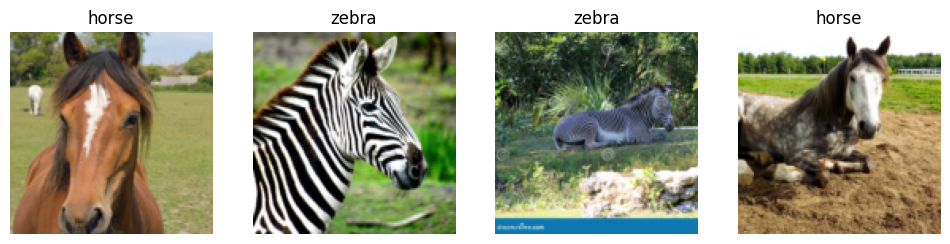

In [52]:
dls.show_batch(max_n=4, nrows=1)

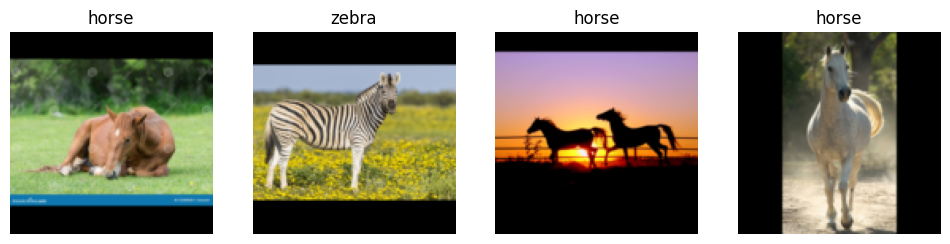

In [53]:
from fastai.vision.all import ResizeMethod

bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(data_dir)
dls.valid.show_batch(max_n=4, nrows=1)

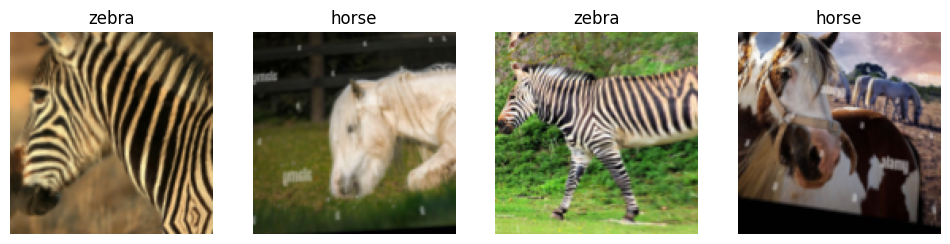

In [54]:
from fastai.vision.all import RandomResizedCrop, aug_transforms

bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3), batch_tfms=aug_transforms())
dls = bears.dataloaders(data_dir)
dls.train.show_batch(max_n=4, nrows=1)

In [55]:
from fastai.vision.all import resnet18

learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time


epoch,train_loss,valid_loss,error_rate,time
0,0.928663,1.789543,0.666667,00:05
1,0.859231,0.595140,0.285714,00:05
2,0.713770,0.334042,0.047619,00:05
3,0.621751,0.333583,0.047619,00:06


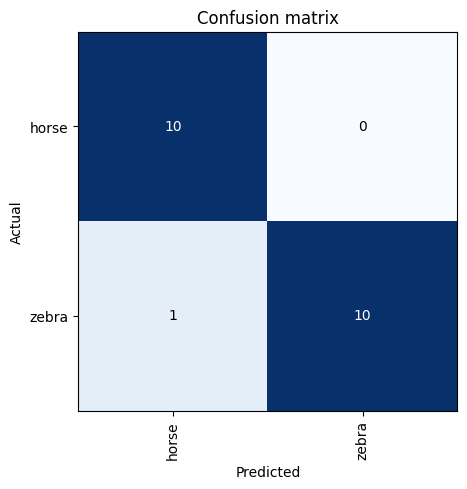

In [56]:
from fastai.vision.all import ClassificationInterpretation

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

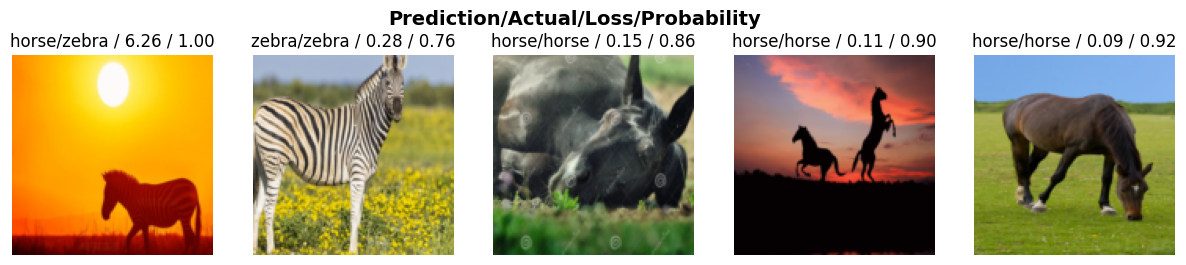

In [57]:
interp.plot_top_losses(5, nrows=1)

The Images cleaner is quite slow over ssh, so commented out. We have some horse silhouettes in there - which is a unfair because technically you can't tell if that's a horse or a zebra.

In [58]:
# Run image cleaner - quite slow over ssh, but looks okay. Note that we have some horse 
# from fastai.vision.widgets import ImageClassifierCleaner

# cleaner = ImageClassifierCleaner(learn)
# display(cleaner)

In [59]:
save_dir = Path("results/02")
save_dir.mkdir(parents=True, exist_ok=True)
learn.export(save_dir / "export.pkl")

### Serving our classifier

Follow instructions here: https://www.tanishq.ai/blog/posts/2021-11-16-gradio-huggingface.html

Live classifier available here: https://huggingface.co/spaces/mkerin/fastai-zebra-horse-classifier